<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.5
## Feature Selection

### Data

**Predict the onset of diabetes based on diagnostic measures.**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

[Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database/download)

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression

#### 1. Load Data

In [6]:
# Read Data
diabetes = pd.read_csv(r'C:\Users\pabarca\OneDrive - GRUPO GRANSOLAR\Desktop\IOD - Python\DATA\diabetes.csv')

#### 2. Perform EDA

Perform EDA. Check Null Values. Impute if necessary.

In [8]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [12]:
# Check Null Values
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

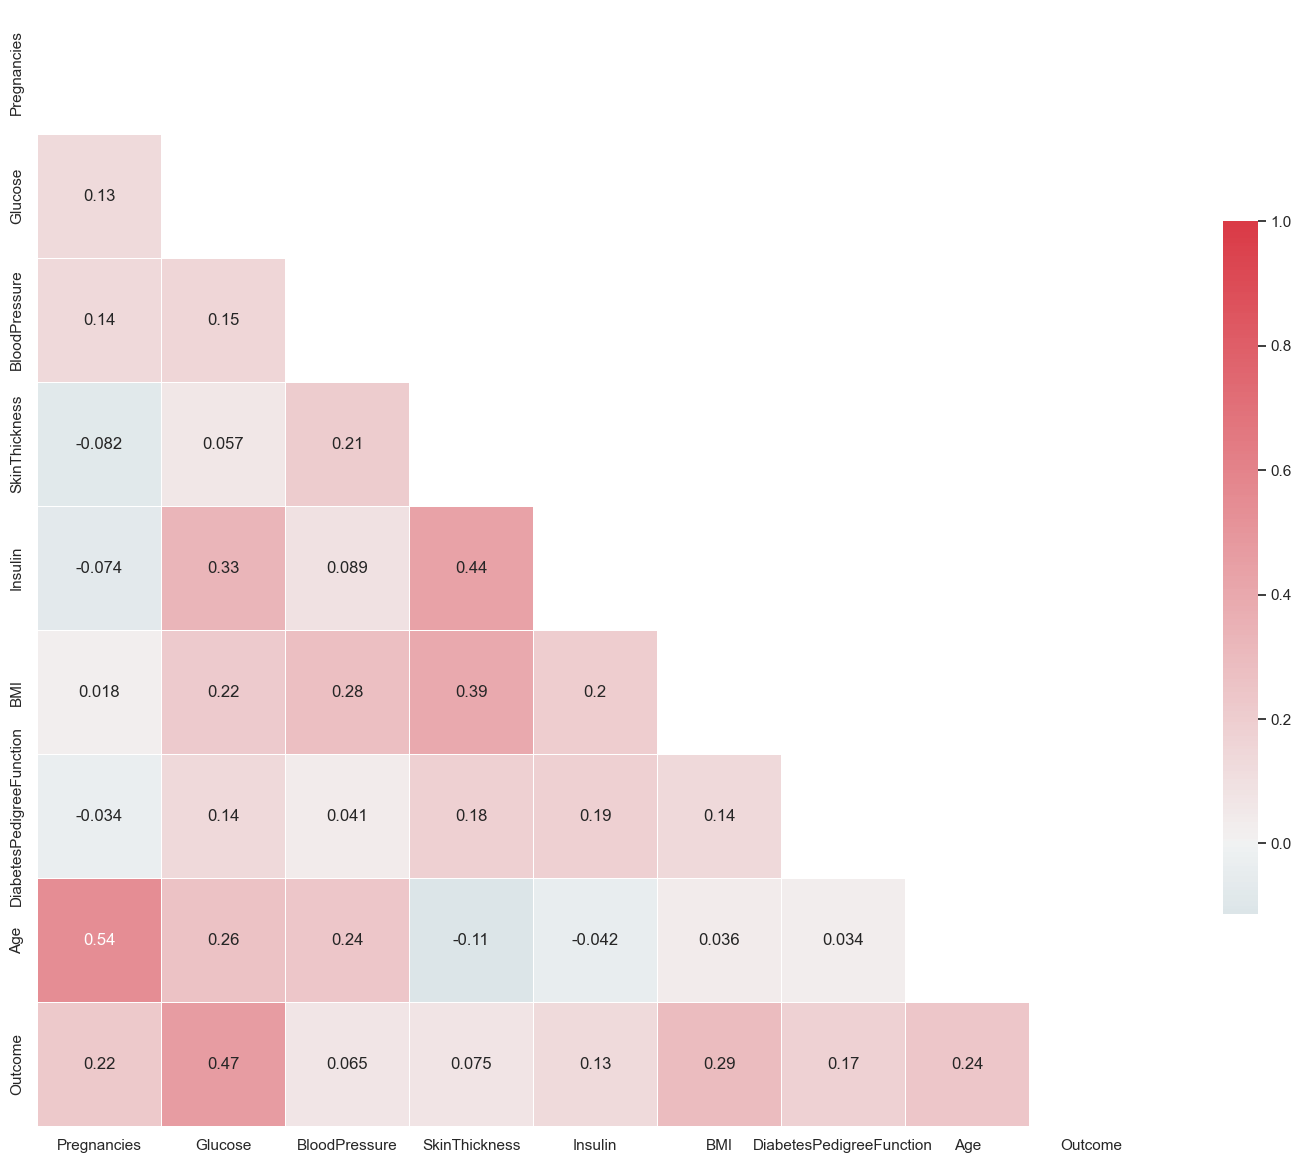

In [22]:
# Copied code from seaborn examples
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
import matplotlib.pyplot as plt
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(diabetes.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(diabetes.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

#### 3. Set Target

- Set `Outcome` as target.
- Set Features

In [24]:
target_column = 'Outcome'
feature_columns = [c for c in diabetes.columns if c != target_column]

In [26]:
feature_columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [28]:
y = diabetes[target_column]
X = diabetes[feature_columns]

#### 4. Select Feature

The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.

##### 4.1 Univariate Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

- SelectKBest removes all but the  highest scoring features
- Use sklearn.feature_selection.chi2 as score function
    > Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.


More Reads:
[Univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

- Create an instance of SelectKBest
    - Use sklearn.feature_selection.chi2 as score_func
    - Use k of your choice
- Fit X, y
- Find top 4 features
- Transform features to a DataFrame

In [30]:
# Create an instance of SelectKBest
kbest = SelectKBest(score_func=chi2, k=4)

In [32]:
# Fit
fit = kbest.fit(X, y)

In [34]:
# Print Score
# Find Top 4 Features
pd.DataFrame(fit.scores_, index=feature_columns)

,0
Pregnancies,111.519691
Glucose,1411.887041
BloodPressure,17.605373
SkinThickness,53.108040
Insulin,2175.565273
BMI,127.669343
DiabetesPedigreeFunction,5.392682
Age,181.303689


In [36]:
# Transform X to Features
features = fit.transform(X)

In [38]:
# Transform features to a dataframe
pd.DataFrame(features)

,0,1,2,3
0,148.0,0.0,33.6,50.0
1,85.0,0.0,26.6,31.0
2,183.0,0.0,23.3,32.0
3,89.0,94.0,28.1,21.0
4,137.0,168.0,43.1,33.0
...,...,...,...,...
763,101.0,180.0,32.9,63.0
764,122.0,0.0,36.8,27.0
765,121.0,112.0,26.2,30.0
766,126.0,0.0,30.1,47.0


##### 4.2 Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

More Reads:
[Recursive feature elimination](https://scikit-learn.org/stable/modules/feature_selection.html)

- Use RFE to extract feature
    - use LogisticRegression as estimator
    - Number of n_features_to_select as of your choice
- Fit X, y to RFE
- Find Selected Features

In [40]:
# feature extraction
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=4)
fit = rfe.fit(X, y)
print("Num Features: %d", fit.n_features_)
print("Selected Features: %s", fit.support_)
print("Feature Ranking: %s", fit.ranking_)

Num Features: %d 4
Selected Features: %s [ True  True False False False  True  True False]
Feature Ranking: %s [1 1 3 4 5 1 1 2]


C:\Users\pabarca\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pabarca\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Step 1: Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Replace X with your features variable

# Step 2: Create a logistic regression model with more iterations
model = LogisticRegression(max_iter=1000)  # Increased from default 100

# Step 3: Apply RFE for feature selection
rfe = RFE(estimator=model, n_features_to_select=4)
fit = rfe.fit(X_scaled, y)  # Use scaled features

# Step 4: Display results
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 4
Selected Features: [ True  True False False False  True  True False]
Feature Ranking: [1 1 2 5 4 1 1 3]


In [46]:
# Print Score
# Find Features
# Print Score
# Find Top 4 Features
pd.DataFrame(fit.support_, index=feature_columns)

,0
Pregnancies,True
Glucose,True
BloodPressure,False
SkinThickness,False
Insulin,False
BMI,True
DiabetesPedigreeFunction,True
Age,False




---



---



> > > > > > > > > © 2025 Institute of Data


---



---



